# Spatial GPflow with functional inputs

First, we load some packages and define useful functions:

In [1]:
#### standard libraries ####
import numpy as np
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from pyDOE import *
from smt.sampling_methods import LHS

#### plot parameters ####
%matplotlib inline

#### GP libraries ####
import tensorflow as tf
import gpflow
from gpflow.utilities import print_summary
from gpflow.utilities import set_trainable
from gpflow.ci_utils import ci_niter
gpflow.config.set_default_summary_fmt("notebook")

#### local functions ####
%run futil.py
%run fkernels.py
%run mo_fkernel.py
%run kronecker_ops.py

## Generating the functional toy example

We propose a synthetic example involving 8 functional inputs and 51 map replicates. We sample random functional profiles from Gaussian processes (GPs) with Matérn 5/2 kernels:

In [2]:
#### generating functional data using GP priors ####
nt = 100 # length of functional (time) series
nf = 8 # nb of functional inputs
nrep = 21 # nb of functional replicates

## defining kernels for the time series ##
variance = .5 # variance parameter
lengthscale_list = np.linspace(.1, .8, nf) #lengthscale parameters
# creating list of nf functional kernels
kern_list = [gpflow.kernels.SquaredExponential(variance=variance,
                                               lengthscale=lengthscale_list[i]) for i in range(nf)]

## simulated nrep random functional samples ##
t = np.linspace(0, 1, nt).reshape(-1,1)
# sampling functions using the Cholesky decomposition for faster computations
np.random.seed(2)
F = [mvrnorm(np.zeros(nt), kern_list[i](t).numpy(), nrep).T for i in range(nf)]
for i in range(nf):
    for j in range(nrep-1):
        np.random.seed(i+j)
        F[i][:,j+1] = F[i][:,0] + 0.05*mvrnorm(np.zeros(nt), kern_list[nf-1](t).numpy(), 1)

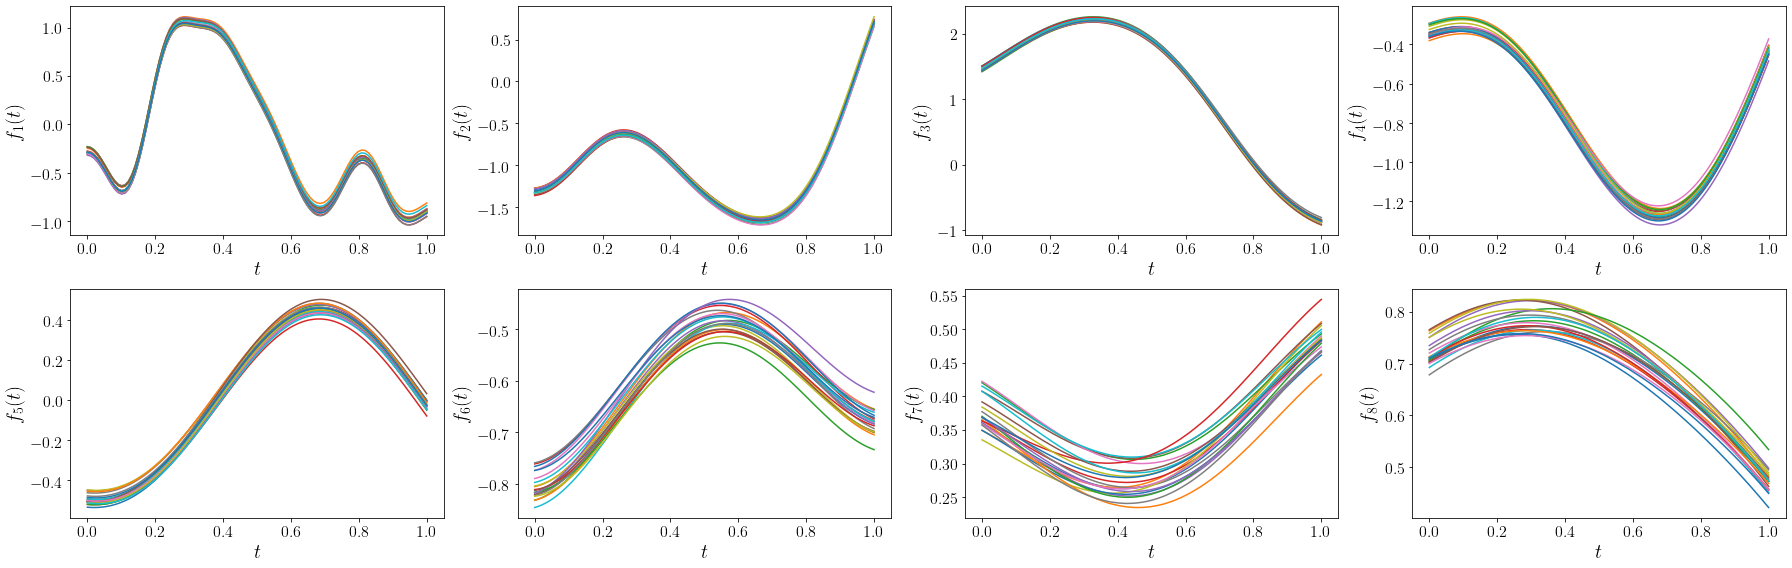

In [3]:
## plotting functional replicates ##
fig, axes = plt.subplots(2, 4, figsize=(25, 8))
idx = 1
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        axes[i,j].plot(t, F[idx-1])
        axes[i,j].set_xlabel('$t$', fontsize=20)
        axes[i,j].set_ylabel(''.join(('$f_{', str(idx), '}(t)$')), fontsize=20)
        idx += 1
plt.tight_layout()

We now define the functional and spatial kernels and generate spatial GP replicates of the ouput:

In [5]:
#### building up the dataset ####
## functional kernel ##
f_list = fproj_list(F, nbterms=nt) # list with functional information (inputs, projection parameters)
U = list(range(nrep)) # integer sequence for indexing functional replicates
np.random.seed(7)
lengthscale_f = np.round(np.repeat(2, nf), 3) # lengthscale parameters for the functional kernel
kf = fMatern52(lengthscale=lengthscale_f, f_list=f_list)

## spatial kernel ##
# computing spatial data #
dim_x = 2 # spatial dimension
ngrid = 100 # nb spatial points per dimension
x = np.linspace(0, 1, ngrid) 
lengthscale_x = (0.2, 0.2)#np.repeat(.2, dim_x) # lengthscale parameters for the functional kernel
ks = [gpflow.kernels.Matern52(lengthscale=lengthscale_i) for lengthscale_i in lengthscale_x]

## computing the list with Cholesky arrays used for sampling ##
L = [np.linalg.cholesky(kf(U).numpy()),
     np.linalg.cholesky(ks[0](x.reshape([-1,1]))),
     np.linalg.cholesky(ks[1](x.reshape([-1,1])))]

## sampling from the spatio-functional kernel ##
np.random.seed(4)
maps = kron_mvrnorm(np.zeros(nrep * ngrid**2), L, 1, isChol=True)
maps = maps.T.reshape(nrep, ngrid, ngrid)

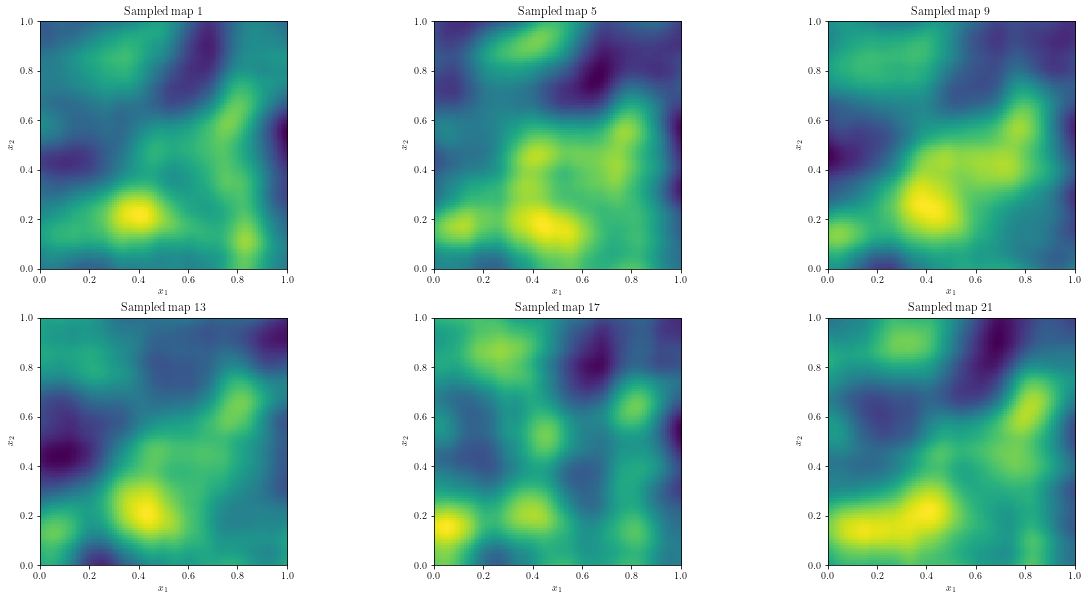

In [6]:
## plotting the nrep sampled spatial maps ##
fig, axes = plt.subplots(2, 3, figsize=(20,10))
maps_idx = np.linspace(0, 1, 6)*(nrep-1)
maps_idx = [np.int(mapi) for mapi in maps_idx]
idx = 1
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        axes[i,j].imshow(maps[maps_idx[idx-1],:,:], origin='lower', extent = (0,1,0,1))
        axes[i,j].set_title(' '.join(('Sampled map', str(maps_idx[idx-1]+1))))
        axes[i,j].set_xlabel('$x_1$')
        axes[i,j].set_ylabel('$x_2$')
        idx += 1

Since we aim at testing the model for predicting maps where there is no spatial information, we will only use data from nrep-1 maps and let the remaining one for prediction purposes. 

In [8]:
#### spatial SVGPflow with functional inputs ####
## separating training and test maps ##
nrep_train = nrep-1
F_train = [Fi[:,:nrep_train] for Fi in F]
f_list_train = fproj_list(F_train) # list with functional information (inputs, projection parameters)

We now fix the design of points used in our experiments:

In [10]:
ntrain = 35
xlimits = np.array([[0.01, 0.99], [0.01, 0.99]])
sampling = LHS(xlimits=xlimits, criterion="ese")

def lhsi(sampling, ntrain, seedi):
    np.random.seed(seedi)
    design = sampling(ntrain)
    return(design)
X_train = [lhsi(sampling, ntrain, i) for i in range(nrep_train)]
idxtrain = [X_train[i]*100. for i in range(nrep_train)]
idxtrain1 = [np.asarray([np.int(idx_temp-1) for idx_temp in idxtrain[i][:,0]]) for i in range(nrep_train)]
idxtrain2 = [np.asarray([np.int(idx_temp-1) for idx_temp in idxtrain[i][:,1]]) for i in range(nrep_train)]
Y_train = [maps[i,idxtrain1[i].flatten(),idxtrain2[i].flatten()].T for i in range(nrep_train)]

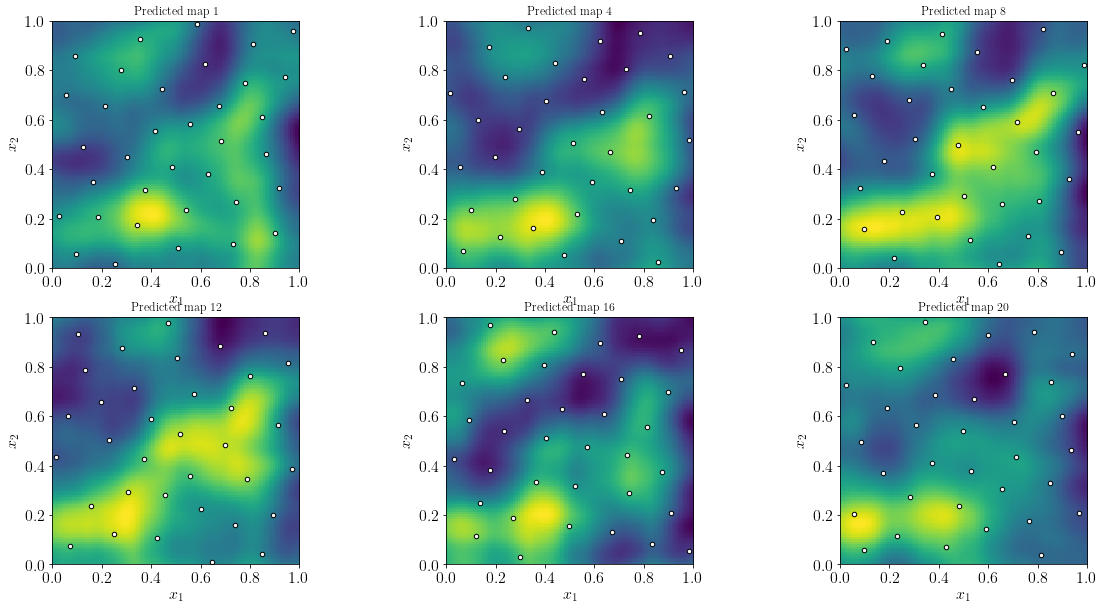

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(20,10))
maps_idx = np.linspace(0, 1, 6)*(nrep_train-1)
maps_idx = [np.int(mapi) for mapi in maps_idx]
idx = 1
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        im = axes[i,j].imshow(maps[maps_idx[idx-1],:,:].reshape(ngrid,ngrid),
                              origin = "lower", extent = (0,1,0,1))
        axes[i,j].set_title(' '.join(('Predicted map', str(maps_idx[idx-1]+1))))
        axes[i,j].set_xlabel('$x_1$', fontsize=16)
        axes[i,j].set_ylabel('$x_2$', fontsize=16)
        axes[i,j].set_xticks(np.linspace(0,1,6))
        axes[i,j].scatter(X_train[idx-1][:, 0], X_train[idx-1][:, 1],
                          marker="o", color="w", edgecolors='k', s=20)
        idx += 1

## Classic multi-output SVGP model

We first extend data using output indices:

In [12]:
X_train_ext = [np.hstack((X_train[i], np.repeat(i, ntrain).reshape(-1,1)))
               for i in range(nrep_train)]
X_train_ext = np.asarray(X_train_ext).reshape(ntrain*nrep_train, 3)
Y_train_ext = np.asarray(Y_train).reshape(-1,1)
nobs = X_train_ext.shape[0]

We now define a classic MO SVGP with a linear coregionalization kernel:

In [13]:
# spatial kernel #
ks_base = gpflow.kernels.Matern52(variance =1., lengthscale=(0.5, 0.5), active_dims=[0,1])

# Coregion kernel #
coreg = gpflow.kernels.Coregion(output_dim=nrep_train, rank=nrep_train, active_dims=[2])
coreg.W.assign(np.random.rand(nrep_train, nrep_train))  # Initialize the W matrix to break symmetry

# mix kernel as a product #
ks = ks_base * coreg

# creating the model #
likelihood = gpflow.likelihoods.Gaussian()
m = gpflow.models.GPR((X_train_ext, Y_train_ext), ks)
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.kernels[0].lengthscale,Parameter,Softplus,,True,"(2,)",float64,[0.5 0.5]
GPR.kernel.kernels[1].W,Parameter,,,True,"(20, 20)",float64,"[[0.41241053, 0.95345876, 0.00536203..."
GPR.kernel.kernels[1].kappa,Parameter,Softplus,,True,"(20,)",float64,"[1., 1., 1...."
GPR.likelihood.variance,Parameter,Softplus + AffineScalar,,True,(),float64,1.0


We now define the optimiser and the cost function to be maximised:

In [14]:
# closure
@tf.function
def objective_closure():
    return - m.log_marginal_likelihood()

# fit the covariance function parameters
maxiter = ci_niter(1000)
start_time = time.time()
gpflow.optimizers.Scipy().minimize(objective_closure, m.trainable_variables,
                                   options=dict(maxiter=maxiter),
                                   method='L-BFGS-B')
lapse_time =  time.time() - start_time
print("Lapse time for training: ", np.float16(lapse_time))

## printing summary optimized model ##
print_summary(m)

Lapse time for training:  133.5


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.0005805552088344831
GPR.kernel.kernels[0].lengthscale,Parameter,Softplus,,True,"(2,)",float64,[0.19957441 0.21868506]
GPR.kernel.kernels[1].W,Parameter,,,True,"(20, 20)",float64,"[[10.50079336, 10.58750559, -0.42292376..."
GPR.kernel.kernels[1].kappa,Parameter,Softplus,,True,"(20,)",float64,"[3.14084596e-02, 4.78617691e-07, 4.26403110e-08..."
GPR.likelihood.variance,Parameter,Softplus + AffineScalar,,True,(),float64,9.999999990529549e-07


We now test the model to predict the entire nrep-1 maps: 

In [15]:
#### predictions at new spatial points over the same training maps ####
ngrid_test = ngrid # nb spatial test points per dimension
x2_test, x1_test = np.meshgrid(x, x) # input spatial grid for testing the model
X_test = np.vstack((x1_test.flatten(), x2_test.flatten())).T 
X_test_ext = [np.hstack((X_test, np.repeat(i, ngrid_test**2).reshape(-1,1)))
              for i in range(nrep_train)]
X_test_ext = np.asarray(X_test_ext).reshape((ngrid_test**2)*nrep_train, 3)

In [16]:
## predictive results ##
start_time = time.time()
mu, var = m.predict_f(X_test_ext)
lapse_time =  time.time() - start_time
print("Lapse time for prediction: ", np.float16(lapse_time))

Lapse time for prediction:  50.06


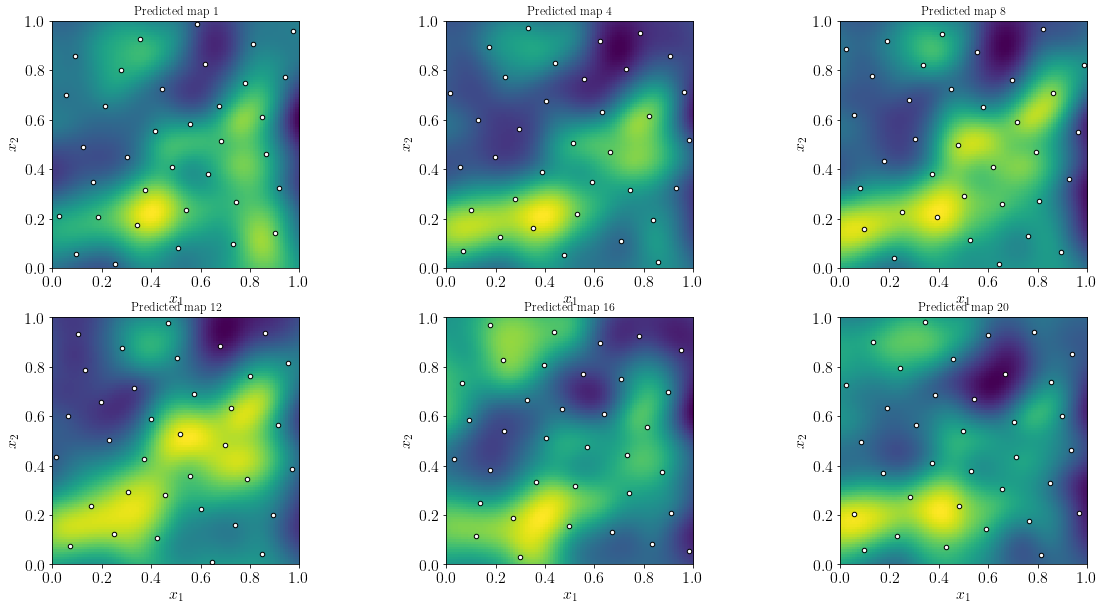

In [17]:
pred = mu.numpy() # predictive mean
pred = pred.reshape(nrep_train, ngrid_test**2).T

## plotting the nrep sampled spatial maps ##
fig, axes = plt.subplots(2, 3, figsize=(20,10))
maps_idx = np.linspace(0, 1, 6)*(nrep_train-1)
maps_idx = [np.int(mapi) for mapi in maps_idx]
idx = 1
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        im = axes[i,j].imshow(pred[:,maps_idx[idx-1]].reshape(ngrid_test,ngrid_test),
                              origin = "lower", extent = (0,1,0,1))
        axes[i,j].set_title(' '.join(('Predicted map', str(maps_idx[idx-1]+1))))
        axes[i,j].set_xlabel('$x_1$', fontsize=16)
        axes[i,j].set_ylabel('$x_2$', fontsize=16)
        axes[i,j].set_xticks(np.linspace(0,1,6))
        axes[i,j].scatter(X_train[idx-1][:, 0], X_train[idx-1][:, 1],
                          marker="o", color="w", edgecolors='k', s=20)
        idx += 1

0.9431852840260869

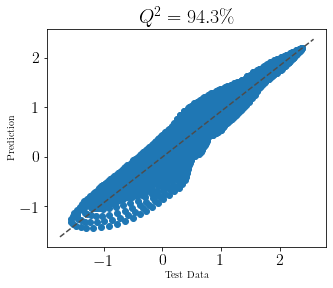

In [20]:
y_test = maps[:nrep_train,:,:].reshape(nrep_train,ngrid**2).T.reshape(-1,1)
y_pred = pred.reshape(-1,1)
q2 =  1. - np.sum((y_test - y_pred)**2)/np.sum((y_test - np.mean(y_test))**2)

fig, axes = plt.subplots(1, 1, figsize=(5,4))
axes.plot(y_test[::20], y_pred[::20], "o")
axes.plot(axes.get_xlim(), axes.get_ylim(), ls="--", c=".3");
axes.set_title(''.join((r"$Q^2=", str(np.round(q2*100., 1)), " \%$")), size=20)
axes.set_xlabel('Test Data'); axes.set_ylabel('Prediction');

q2

## Multi-output SVGP model with functional coregionalization kernel

We now define an MO SVGP with a functional linear coregionalization kernel:

In [21]:
# spatial kernel #
ks_base = gpflow.kernels.Matern52(variance =1., lengthscale=(0.5, 0.5), active_dims=[0,1])

# Coregion kernel #
distances_f = [dist2ff(coef_i, coef_j, f_list_train[2])
               for coef_i in f_list_train[1] for coef_j in f_list_train[1]]
kf = fMatern52(lengthscale=np.repeat(0.5, nf), active_dims=[2],
               f_list=f_list_train, distances=distances_f)

# mix kernel as a product #
ksf = ks_base * kf

# creating the model #
likelihood = gpflow.likelihoods.Gaussian()
mf = gpflow.models.GPR((X_train_ext, Y_train_ext), ksf)
set_trainable(mf.kernel.kernels[1].variance, False)
print_summary(mf)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.kernels[0].lengthscale,Parameter,Softplus,,True,"(2,)",float64,[0.5 0.5]
GPR.kernel.kernels[1].variance,Parameter,Softplus,,False,(),float64,1.0
GPR.kernel.kernels[1].lengthscale,Parameter,Softplus,,True,"(8,)",float64,"[0.5, 0.5, 0.5..."
GPR.likelihood.variance,Parameter,Softplus + AffineScalar,,True,(),float64,1.0


In [22]:
# closure
@tf.function
def objective_closure():
    return - mf.log_marginal_likelihood()

# fit the covariance function parameters
maxiter = ci_niter(1000)
start_time = time.time()
gpflow.optimizers.Scipy().minimize(objective_closure, mf.trainable_variables,
                                   options=dict(maxiter=maxiter),
                                   method='L-BFGS-B')
lapse_time =  time.time() - start_time
print("Lapse time for training: ", np.float16(lapse_time))

## printing summary optimized model ##
print_summary(mf)

Lapse time for training:  50.22


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.9567443117264522
GPR.kernel.kernels[0].lengthscale,Parameter,Softplus,,True,"(2,)",float64,[0.19747023 0.20671523]
GPR.kernel.kernels[1].variance,Parameter,Softplus,,False,(),float64,1.0
GPR.kernel.kernels[1].lengthscale,Parameter,Softplus,,True,"(8,)",float64,"[2.56710329, 1.84289114, 1.83336063..."
GPR.likelihood.variance,Parameter,Softplus + AffineScalar,,True,(),float64,2.4633228306453923e-06


In [23]:
## predictive results ##
start_time = time.time()
muf, varf = mf.predict_f(X_test_ext)
lapse_time =  time.time() - start_time
print("Lapse time for prediction: ", np.float16(lapse_time))

Lapse time for prediction:  59.3


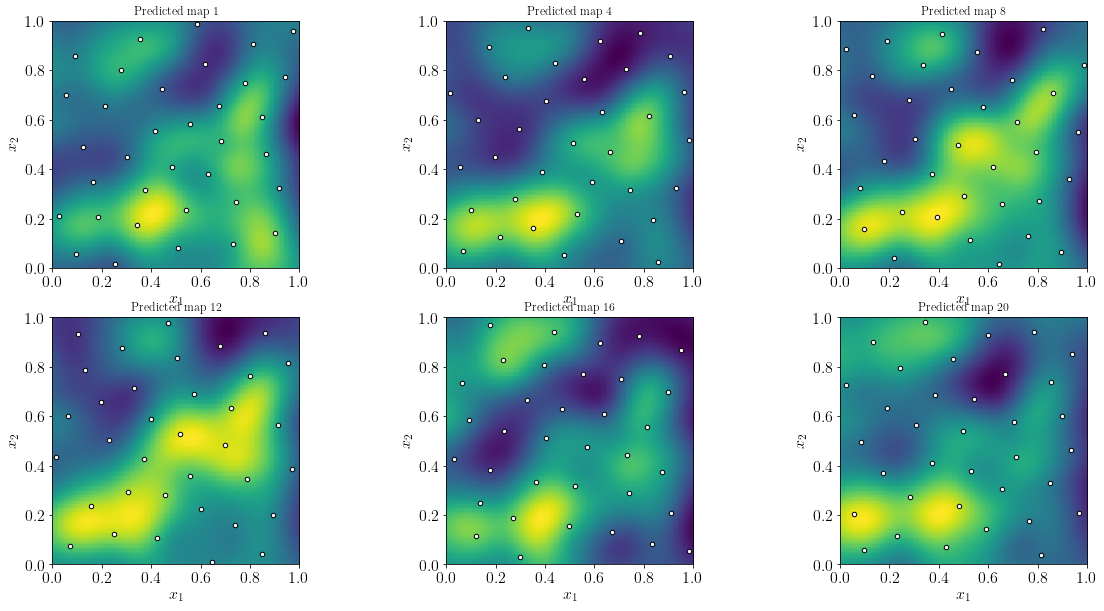

In [24]:
## plotting the nrep sampled spatial maps ##
predf = muf.numpy()#.reshape(ngrid_test,ngrid_test, nrep) # predictive mean
predf = predf.reshape(nrep_train, ngrid_test**2).T

fig, axes = plt.subplots(2, 3, figsize=(20,10))
maps_idx = np.linspace(0, 1, 6)*(nrep_train-1)
maps_idx = [np.int(mapi) for mapi in maps_idx]
idx = 1
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        im = axes[i,j].imshow(predf[:,maps_idx[idx-1]].reshape(ngrid_test,ngrid_test),
                              origin = "lower", extent = (0,1,0,1))
        axes[i,j].set_title(' '.join(('Predicted map', str(maps_idx[idx-1]+1))))
        axes[i,j].set_xlabel('$x_1$', fontsize=16)
        axes[i,j].set_ylabel('$x_2$', fontsize=16)
        axes[i,j].set_xticks(np.linspace(0,1,6))
        axes[i,j].scatter(X_train[idx-1][:, 0], X_train[idx-1][:, 1],
                          marker="o", color="w", edgecolors='k', s=20)
        idx += 1

0.9595525933446668

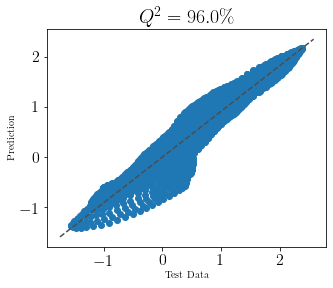

In [26]:
y_test = maps[:nrep_train,:,:].reshape(nrep_train,ngrid**2).T.reshape(-1,1)
y_predf = predf.reshape(-1,1)
q2f =  1. - np.sum((y_test - y_predf)**2)/np.sum((y_test - np.mean(y_test))**2)

fig, axes = plt.subplots(1, 1, figsize=(5,4))
axes.plot(y_test[::20], y_predf[::20], "o")
axes.plot(axes.get_xlim(), axes.get_ylim(), ls="--", c=".3");
axes.set_title(''.join((r"$Q^2=", str(np.round(q2f*100., 1)), " \%$")), size=20)
axes.set_xlabel('Test Data'); axes.set_ylabel('Prediction');
axes.tick_params(axis='x', labelsize=16)
axes.tick_params(axis='y', labelsize=16)

q2f

We now plot the resulting coregionalization matrices for both models:

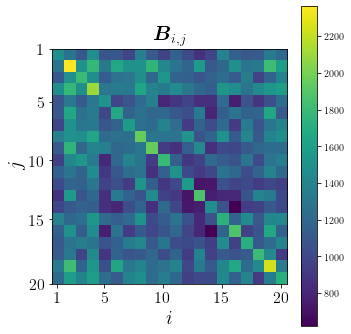

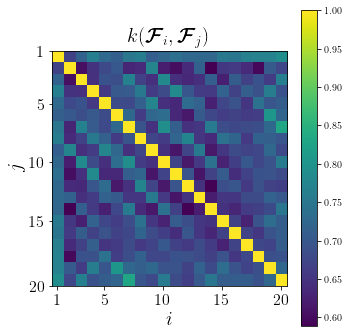

In [27]:
B = m.kernel.kernels[1].W.numpy() @ m.kernel.kernels[1].W.numpy().T + np.diag(m.kernel.kernels[1].kappa.numpy())
kf2 = fMatern52(lengthscale=mf.kernel.kernels[1].lengthscale,
               f_list=mf.kernel.kernels[1].f_list, distances=mf.kernel.kernels[1].distances) 
Kf = kf2(list(range(nrep_train)))

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
im = axes.imshow(B)
axes.set_title(r"$\boldsymbol{B}_{i,j}$", size=20)
axes.set_xlabel('$i$', fontsize=20)
axes.set_ylabel('$j$', fontsize=20)
axes.set_xticks((0.,4.,9.,14.,19.))
axes.set_xticklabels((1,5,10,15,20))
axes.set_yticks((-.5,4.,9,14,19.5))
axes.set_yticklabels((1,5,10,15,20))
fig.colorbar(im, ax=axes)
plt.tight_layout()

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
im = axes.imshow(Kf)
axes.set_title(r"$k(\boldsymbol{\mathcal{F}}_i, \boldsymbol{\mathcal{F}}_j)$", size=20)
axes.set_xlabel('$i$', fontsize=20)
axes.set_ylabel('$j$', fontsize=20)
axes.set_xticks((0.,4.,9.,14.,19.))
axes.set_xticklabels((1,5,10,15,20))
axes.set_yticks((-.5,4.,9,14,19.5))
axes.set_yticklabels((1,5,10,15,20))
fig.colorbar(im, ax=axes)
plt.tight_layout()